In [ ]:
# IMAGE_DIR = '../data/processed/obj_bkgr/daytime'
# LABEL_DIR = '../data/processed/obj_bkgr/daytime'
# OUTPUT_IMAGE_DIR = '../data/processed/augmented/daytime'
# OUTPUT_LABEL_DIR = '../data/processed/augmented/daytime'

IMAGE_DIR = '../data/processed/obj_bkgr/nighttime'
LABEL_DIR = '../data/processed/obj_bkgr/nighttime'
OUTPUT_IMAGE_DIR = '../data/processed/augmented/nighttime'
OUTPUT_LABEL_DIR = '../data/processed/augmented/nighttime'

In [ ]:
import os
import cv2
import albumentations as A
from tqdm import tqdm
import shutil
import numpy as np
import random

# Định nghĩa các lớp thiểu số (ví dụ: bus và truck với class_id 2 và 3)
MINORITY_CLASSES = [2, 3]

# Tạo thư mục đầu ra nếu chưa tồn tại
os.makedirs(OUTPUT_IMAGE_DIR, exist_ok=True)
os.makedirs(OUTPUT_LABEL_DIR, exist_ok=True)

# Kích thước đầu vào cho các ảnh
HEIGHT = 640
WIDTH = 640

# Hàm đọc nhãn từ file YOLO
def read_yolo_labels(label_path, img_width, img_height):
    boxes = []
    class_ids = []
    with open(label_path, 'r') as file:
        for line in file:
            parts = line.strip().split()
            if len(parts) != 5:
                continue
            class_id, x_center, y_center, width, height = map(float, parts)
            # Chuyển đổi từ YOLO format (normalized) sang pixel coordinates
            x_center *= img_width
            y_center *= img_height
            width *= img_width
            height *= img_height
            x_min = max(x_center - width / 2, 0)
            y_min = max(y_center - height / 2, 0)
            x_max = min(x_center + width / 2, img_width)
            y_max = min(y_center + height / 2, img_height)
            boxes.append([x_min, y_min, x_max, y_max])
            class_ids.append(int(class_id))
    return boxes, class_ids

# Hàm ghi nhãn vào file YOLO
def write_yolo_labels(label_path, boxes, class_ids, img_width, img_height):
    with open(label_path, 'w') as file:
        for box, class_id in zip(boxes, class_ids):
            x_min, y_min, x_max, y_max = box
            # Đảm bảo các giá trị nằm trong phạm vi [0, img_width] và [0, img_height]
            x_min = np.clip(x_min, 0, img_width)
            y_min = np.clip(y_min, 0, img_height)
            x_max = np.clip(x_max, 0, img_width)
            y_max = np.clip(y_max, 0, img_height)
            x_center = (x_min + x_max) / 2 / img_width
            y_center = (y_min + y_max) / 2 / img_height
            width = (x_max - x_min) / img_width
            height = (y_max - y_min) / img_height
            # Kiểm tra các giá trị hợp lệ
            if width > 0 and height > 0:
                file.write(f"{int(class_id)} {x_center:.6f} {y_center:.6f} {width:.6f} {height:.6f}\n")

# Hàm để lấy một giá trị ngẫu nhiên trong khoảng cho brightness
def get_random_brightness():
    return random.uniform(0.5, 1.0)  # Brightness coefficient luôn <= 1

def get_random_brightness_snow():
    return random.uniform(0.8, 1.0)  # Điều chỉnh giá trị hợp lý cho snow

def get_random_fog_alpha():
    return random.uniform(0.03, 0.07)  # Giá trị alpha nhỏ để tạo hiệu ứng nhẹ nhàng

def get_random_clipe_limit():
    return random.uniform(1.0, 2.0)  # Giá trị cho CLAHE, không liên quan đến lỗi nhưng hợp lý hơn

# Định nghĩa pipeline augmentation
def get_augmentation_pipeline(height, width):
    return A.Compose([
        A.RandomScale(scale_limit=0.3, p=0.6),

        A.PadIfNeeded(min_height=height, min_width=width, border_mode=cv2.BORDER_CONSTANT, value=0, p=0.5),
        
        A.RandomSizedBBoxSafeCrop(height=height, width=width, p=0.8, 
                                  min_visibility=0.3),

        # Biến đổi hình học
        A.OneOf([
            A.HorizontalFlip(p=0.5),
            A.Rotate(limit=(-15, 15), p=0.5),
            A.Affine(scale=(0.95, 1.05), translate_percent=(0.05, 0.1), rotate=(-10, 10), shear=(-5, 5), p=0.5),
        ], p=0.7),

        # Hiệu ứng thời tiết với giới hạn
        A.OneOf([
            A.RandomRain(
                slant_lower=-5, 
                slant_upper=5, 
                drop_length=7, 
                drop_width=1, 
                blur_value=2, 
                brightness_coefficient=get_random_brightness(),
                p=0.5
            ),
            A.RandomSnow(
                snow_point_lower=0.05, 
                snow_point_upper=0.15, 
                brightness_coeff=get_random_brightness_snow(),
                p=0.5
            ),
            A.RandomFog(
                fog_coef_lower=0.03, 
                fog_coef_upper=0.15, 
                alpha_coef=get_random_fog_alpha(),
                p=0.5
            ),
            A.RandomSunFlare(
                flare_roi=(0.2, 0.2, 0.8, 0.6), 
                angle_lower=0, 
                angle_upper=0.3, 
                src_radius=40, 
                p=0.5
            ),  # Giảm kích thước flare
            A.RandomShadow(
                shadow_roi=(0.1, 0.1, 0.9, 0.6), 
                num_shadows_lower=1, 
                num_shadows_upper=2, 
                shadow_dimension=3, 
                p=0.5
            )  # Giảm shadow_dimension
        ], p=0.4),

        # Noise
        A.OneOf([
            A.ISONoise(color_shift=(0.01, 0.03), intensity=(0.1, 0.2), p=0.3),
            A.GaussNoise(var_limit=(5.0, 10.0), mean=0, p=0.3),
        ], p=0.3),

        # Làm mờ
        A.OneOf([
            A.MotionBlur(blur_limit=3, p=0.5),
            A.MedianBlur(blur_limit=3, p=0.3),
        ], p=0.3),

        A.OneOf([
            A.RandomBrightnessContrast(brightness_limit=(-0.1, 0.4), contrast_limit=0.0, p=0.4),
            A.HueSaturationValue(hue_shift_limit=5, sat_shift_limit=10, val_shift_limit=10, p=0.4),
            A.CLAHE(clip_limit=get_random_clipe_limit(), tile_grid_size=(8, 8), p=0.3)
        ], p=0.4),

        A.CoarseDropout(
            max_holes=8,
            max_height=16,
            max_width=16,
            min_holes=4,
            min_height=8,
            min_width=8,
            fill_value=0,
            p=0.3
        ),

    ],
    bbox_params=A.BboxParams(
        format='pascal_voc', 
        label_fields=['labels'],
        min_visibility=0.1
    ))

# Lấy danh sách tất cả các ảnh
image_files = [f for f in os.listdir(IMAGE_DIR) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

# Tạo một pipeline augmentation
augmentation = get_augmentation_pipeline(HEIGHT, WIDTH)

# In the main loop, after the file checks
for img_file in tqdm(image_files, desc="Augmenting images"):
    img_path = os.path.join(IMAGE_DIR, img_file)
    label_path = os.path.join(LABEL_DIR, os.path.splitext(img_file)[0] + '.txt')

    # Always copy original image and label first
    shutil.copy(img_path, os.path.join(OUTPUT_IMAGE_DIR, img_file))
    shutil.copy(label_path, os.path.join(OUTPUT_LABEL_DIR, os.path.splitext(img_file)[0] + '.txt'))

    # Read image
    image = cv2.imread(img_path)
    if image is None:
        print(f"Không thể đọc ảnh: {img_path}")
        continue
    img_height, img_width = image.shape[:2]

    # Read labels
    if not os.path.exists(label_path):
        print(f"Không tìm thấy file nhãn: {label_path}")
        continue
    boxes, class_ids = read_yolo_labels(label_path, img_width, img_height)

    # Check for minority classes
    contains_minority = any(cls in MINORITY_CLASSES for cls in class_ids)

    if contains_minority:
        # Create 3 augmented versions for minority class images
        for aug_idx in range(3):
            try:
                transformed = augmentation(image=image, bboxes=boxes, labels=class_ids)
                
                transformed_image = transformed['image']
                transformed_boxes = transformed['bboxes']
                transformed_labels = transformed['labels']

                # Validate boxes
                valid_boxes = []
                valid_labels = []
                for box, cls in zip(transformed_boxes, transformed_labels):
                    x_min, y_min, x_max, y_max = box
                    if x_min >= 0 and y_min >= 0 and x_max > x_min and y_max > y_min:
                        valid_boxes.append(box)
                        valid_labels.append(cls)
                
                if valid_boxes:
                    # Save augmented image with suffix
                    base_name = os.path.splitext(img_file)[0]
                    ext = os.path.splitext(img_file)[1]
                    aug_img_name = f"{base_name}_aug_{aug_idx}{ext}"
                    aug_label_name = f"{base_name}_aug_{aug_idx}.txt"
                    
                    output_img_path = os.path.join(OUTPUT_IMAGE_DIR, aug_img_name)
                    output_label_path = os.path.join(OUTPUT_LABEL_DIR, aug_label_name)

                    # Save image
                    if transformed_image.dtype != np.uint8:
                        transformed_image = transformed_image.astype('uint8')
                    transformed_image = cv2.cvtColor(transformed_image, cv2.COLOR_RGB2BGR)
                    cv2.imwrite(output_img_path, transformed_image)

                    # Save labels
                    write_yolo_labels(output_label_path, valid_boxes, valid_labels, WIDTH, HEIGHT)
                    
            except ValueError as e:
                print(f"Lỗi khi augment ảnh {img_file} (lần {aug_idx}): {e}")
                continue

print("Augmentation hoàn thành!")


/var/folders/h3/4_pq_7pd3pq2286xkp78c1480000gn/T/ipykernel_35031/1795855396.py:87: UserWarning: Argument 'min_visibility' is not valid and will be ignored.
  A.RandomSizedBBoxSafeCrop(height=height, width=width, p=0.8,
Augmenting images: 100%|██████████| 4629/4629 [00:21<00:00, 217.04it/s]

Augmentation hoàn thành!


Data splitting completed.
Training samples: 15724
Validation samples: 4493
Testing samples: 2247


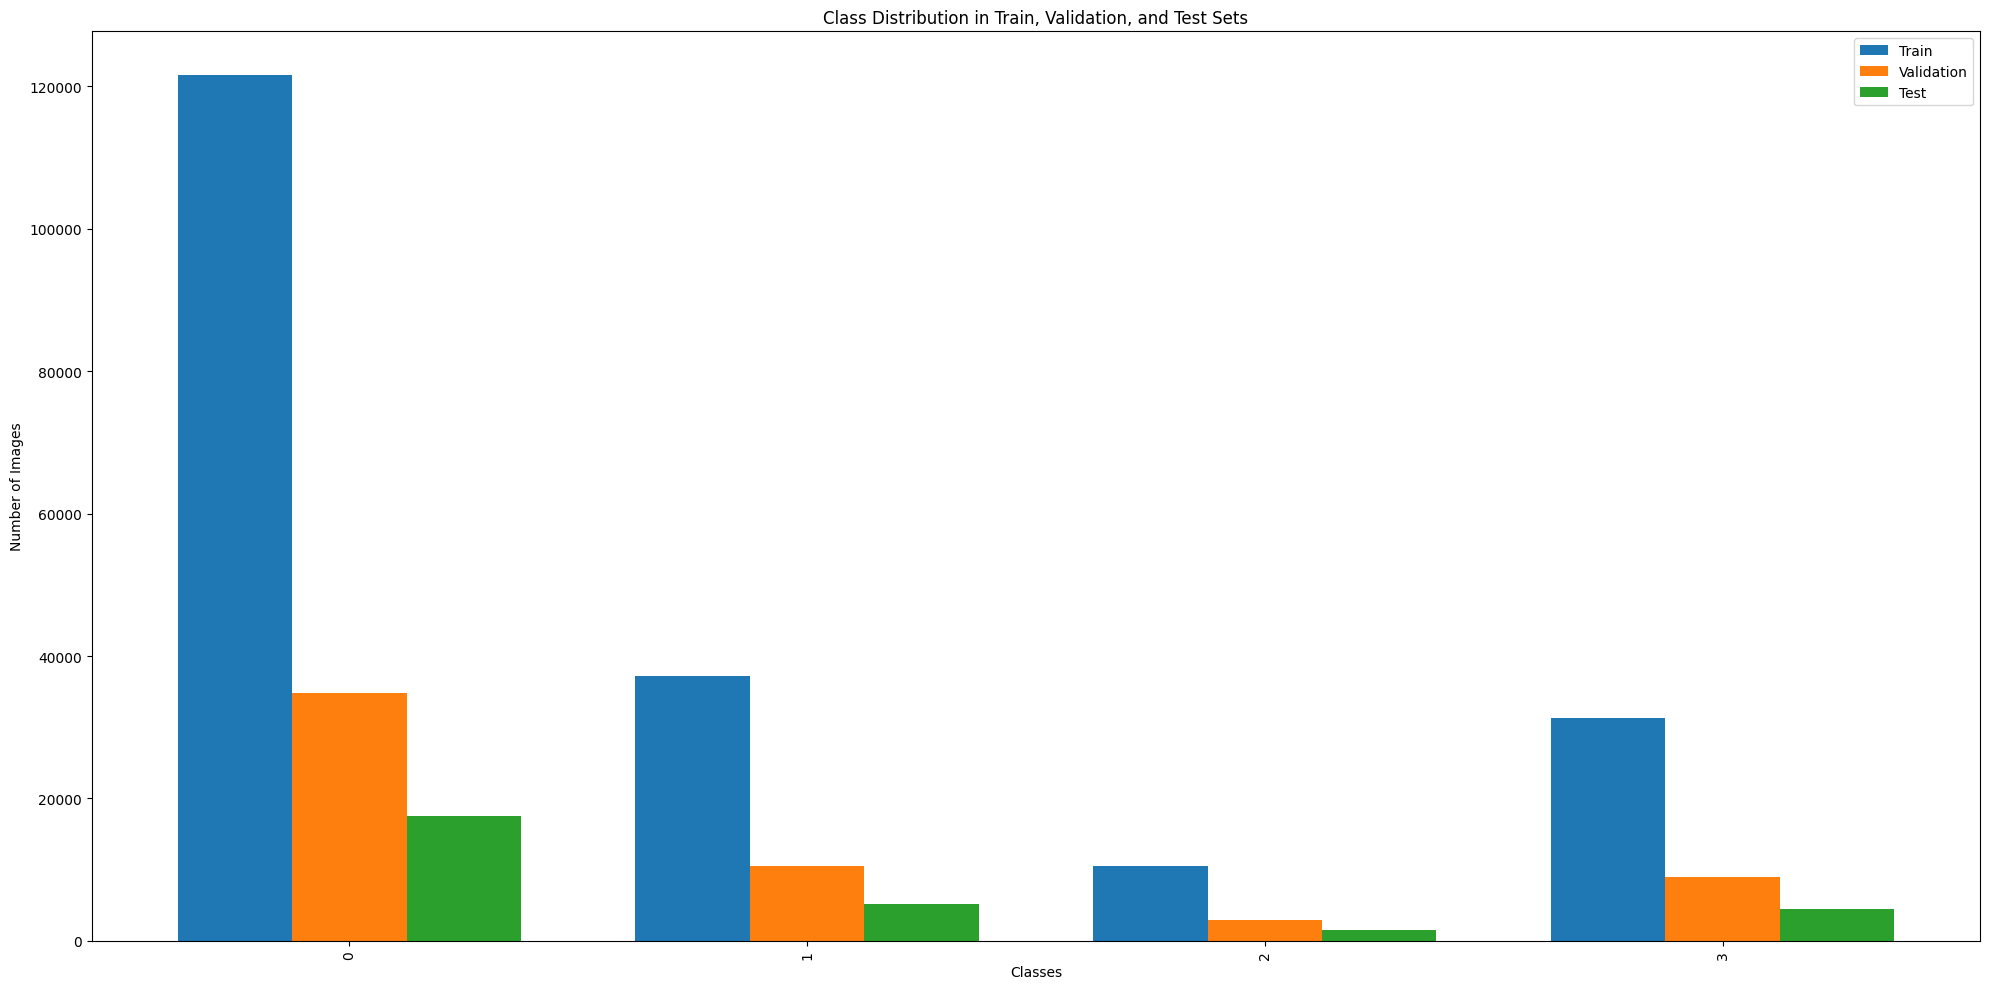

In [ ]:
# Visualize distributions các class ban ngày
from pdatakit.pod.data_processor import DataProcessor

dp = DataProcessor(OUTPUT_IMAGE_DIR)
dp.split_data()
dp.visualize_distributions()

Data splitting completed.
Training samples: 3232
Validation samples: 923
Testing samples: 474


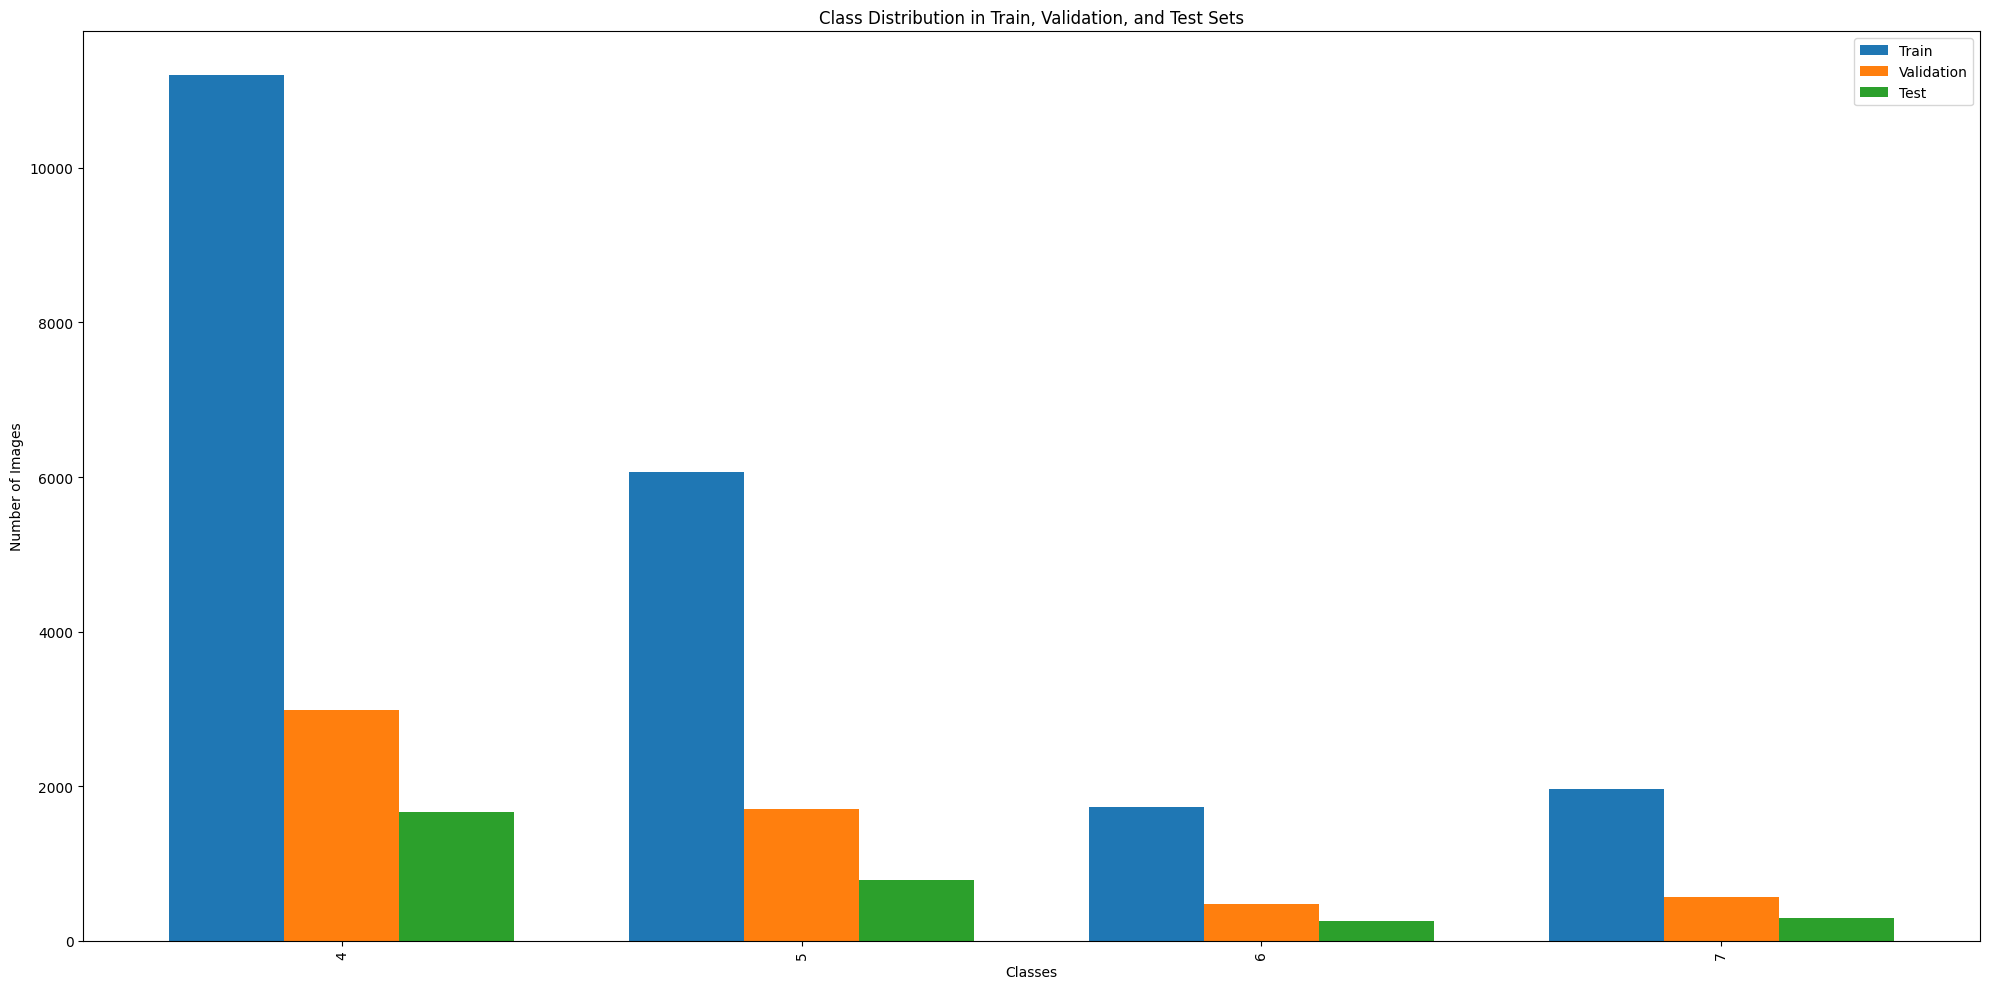

In [ ]:
# visualize distributions các class ban đêm
from pdatakit.pod.data_processor import DataProcessor

dp = DataProcessor(OUTPUT_IMAGE_DIR)
dp.split_data()
dp.visualize_distributions()